In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from scipy import stats


In [ ]:
def load_cmapss_dataset(data_dir='./', dataset_id='FD001'):
    """
    Load training, test and RUL data for a specific engine dataset

    Parameters:
    data_dir (str): Directory containing the data files
    dataset_id (str): Dataset ID ('FD001', 'FD002', 'FD003', or 'FD004')

    Returns:
    dict: Dictionary containing train, test and RUL data
    """
    # Define file paths
    train_file = os.path.join(data_dir, f'/content/drive/MyDrive/TimeSeriePrj/TimeSerieDataSet/CMAPSSData/train_{dataset_id}.txt')
    test_file = os.path.join(data_dir, f'/content/drive/MyDrive/TimeSeriePrj/TimeSerieDataSet/CMAPSSData/test_{dataset_id}.txt')
    rul_file = os.path.join(data_dir, f'/content/drive/MyDrive/TimeSeriePrj/TimeSerieDataSet/CMAPSSData/RUL_{dataset_id}.txt')

    # Define column names
    sensor_columns = [f'sensor_{i}' for i in range(1, 22)]
    op_setting_columns = ['op_setting_1', 'op_setting_2', 'op_setting_3']
    columns = ['engine_id', 'cycle'] + op_setting_columns + sensor_columns

    # Load train data
    train_data = pd.read_csv(train_file, sep=' ', header=None)
    train_data.drop(columns=[26, 27], inplace=True)  # Remove NaN columns
    train_data.columns = columns

    # Load test data
    test_data = pd.read_csv(test_file, sep=' ', header=None)
    test_data.drop(columns=[26, 27], inplace=True)  # Remove NaN columns
    test_data.columns = columns

    # Load RUL data
    rul_data = pd.read_csv(rul_file, sep=' ', header=None)
    rul_data.drop(columns=[1], inplace=True)  # Remove NaN column
    rul_data.columns = ['RUL']

    return {
        'train': train_data,
        'test': test_data,
        'rul': rul_data
    }

def preprocess_cmapss_data(data, calculate_rul=True, normalize=True, drop_sensors=None):
    """
    Preprocess the C-MAPSS data

    Parameters:
    data (DataFrame): Raw data from C-MAPSS dataset
    calculate_rul (bool): Whether to calculate RUL
    normalize (bool): Whether to normalize features
    drop_sensors (list): List of sensor indices to drop (if any)

    Returns:
    DataFrame: Preprocessed data
    """
    df = data.copy()

    # Drop sensors that might not be useful
    if drop_sensors:
        sensors_to_drop = [f'sensor_{i}' for i in drop_sensors]
        df.drop(columns=sensors_to_drop, inplace=True)

    # Calculate RUL (Remaining Useful Life)
    if calculate_rul:
        # Group by engine_id and get max cycle for each engine
        max_cycles = df.groupby('engine_id')['cycle'].max().reset_index()
        max_cycles.columns = ['engine_id', 'max_cycle']

        # Merge with original data
        df = df.merge(max_cycles, on='engine_id', how='left')

        # Calculate RUL
        df['RUL'] = df['max_cycle'] - df['cycle']
        df.drop('max_cycle', axis=1, inplace=True)

    # Normalize data if requested
    if normalize:
        # Identify non-feature columns that shouldn't be normalized
        non_feature_cols = ['engine_id', 'cycle']
        if 'RUL' in df.columns:
            non_feature_cols.append('RUL')

        # Get feature columns
        feature_cols = [col for col in df.columns if col not in non_feature_cols]

        # Group by operating conditions for FD002 and FD004
        if 'op_setting_1' in df.columns and df['op_setting_1'].nunique() > 1:
            # If multiple operating conditions exist (like in FD004)
            # Create a condition identifier for normalization within condition
            df['op_condition'] = df.apply(lambda x: f"{x['op_setting_1']}_{x['op_setting_2']}_{x['op_setting_3']}", axis=1)

            # Normalize within each operating condition
            normalized_dfs = []

            for condition, group in df.groupby('op_condition'):
                group_copy = group.copy()
                scaler = StandardScaler()
                group_copy[feature_cols] = scaler.fit_transform(group_copy[feature_cols])
                normalized_dfs.append(group_copy)

            df = pd.concat(normalized_dfs, axis=0)

            # Drop the temporary condition column
            if 'op_condition' in df.columns:
                df.drop('op_condition', axis=1, inplace=True)
        else:
            # Simple normalization for single operating condition
            scaler = StandardScaler()
            df[feature_cols] = scaler.fit_transform(df[feature_cols])

    return df

def split_by_engine(data):
    """
    Split the data by engine_id

    Parameters:
    data (DataFrame): Preprocessed data with engine_id

    Returns:
    dict: Dictionary with engine_id as keys and DataFrames as values
    """
    engine_data = {}
    for engine_id, group in data.groupby('engine_id'):
        engine_data[engine_id] = group.sort_values('cycle').reset_index(drop=True)

    return engine_data

def create_sequences(df, sequence_length=30, step=1, target_col=None):
    """
    Create sequences for multivariate time series modeling

    Parameters:
    df (DataFrame): Input data
    sequence_length (int): Length of each sequence
    step (int): Step size between sequences
    target_col (str): Target column name (if applicable)

    Returns:
    numpy arrays: X sequences and y targets (if target_col is provided)
    """
    # Remove non-feature columns
    feature_df = df.drop(['engine_id', 'cycle'], axis=1)

    if target_col and target_col in feature_df.columns:
        # Split features and target
        y_data = feature_df[target_col].values
        X_data = feature_df.drop(target_col, axis=1).values

        X_sequences = []
        y_sequences = []

        for i in range(0, len(X_data) - sequence_length, step):
            X_sequences.append(X_data[i:i+sequence_length])
            y_sequences.append(y_data[i+sequence_length])

        return np.array(X_sequences), np.array(y_sequences)
    else:
        # Just features, no target
        X_data = feature_df.values
        X_sequences = []

        for i in range(0, len(X_data) - sequence_length + 1, step):
            X_sequences.append(X_data[i:i+sequence_length])

        return np.array(X_sequences)

In [ ]:
def build_lstm_autoencoder(input_shape, encoding_dim=16):
    """
    Build LSTM Autoencoder for anomaly detection

    Parameters:
    input_shape (tuple): Shape of input sequences (sequence_length, n_features)
    encoding_dim (int): Dimension of the encoding layer

    Returns:
    tuple: (encoder, autoencoder) models
    """
    # Define input layer
    inputs = Input(shape=input_shape)

    # Encoder
    encoded = LSTM(32, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(encoding_dim, activation='relu')(encoded)

    # Bottleneck representation
    encoded_input = Input(shape=(encoding_dim,))

    # Decoder
    decoded = RepeatVector(input_shape[0])(encoded)
    decoded = LSTM(encoding_dim, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_shape[1]))(decoded)

    # Autoencoder model
    autoencoder = Model(inputs, decoded)

    # Encoder model
    encoder = Model(inputs, encoded)

    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mse')

    return encoder, autoencoder

def train_lstm_autoencoder(X_train, epochs=50, batch_size=32, validation_split=0.1):
    """
    Train LSTM Autoencoder model

    Parameters:
    X_train (numpy.ndarray): Training sequences
    epochs (int): Number of training epochs
    batch_size (int): Batch size for training
    validation_split (float): Proportion of data to use for validation

    Returns:
    tuple: (encoder, autoencoder, history)
    """
    input_shape = (X_train.shape[1], X_train.shape[2])
    encoder, autoencoder = build_lstm_autoencoder(input_shape)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the autoencoder
    history = autoencoder.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping],
        verbose=0
    )

    return encoder, autoencoder, history

def detect_anomalies_lstm(X_data, autoencoder, threshold_multiplier=3.0):
    """
    Detect anomalies using LSTM Autoencoder

    Parameters:
    X_data (numpy.ndarray): Data sequences to evaluate
    autoencoder (Model): Trained autoencoder model
    threshold_multiplier (float): Multiplier for anomaly threshold

    Returns:
    tuple: (anomaly_scores, anomaly_flags, threshold)
    """
    # Calculate reconstruction error
    reconstructions = autoencoder.predict(X_data)
    mse = np.mean(np.square(X_data - reconstructions), axis=(1, 2))

    # Calculate threshold (mean + std * multiplier)
    threshold = np.mean(mse) + threshold_multiplier * np.std(mse)

    # Flag anomalies
    anomaly_flags = mse > threshold

    return mse, anomaly_flags, threshold

def detect_anomalies_statistical(X_data, window_size=10, threshold_multiplier=3.0):
    """
    Detect anomalies using statistical methods (Z-score) on time series data

    Parameters:
    X_data (numpy.ndarray): Data sequences to evaluate
    window_size (int): Size of the sliding window for local anomaly detection
    threshold_multiplier (float): Multiplier for anomaly threshold

    Returns:
    tuple: (anomaly_scores, anomaly_flags, threshold)
    """
    # Reshape data for easier processing
    n_samples, seq_len, n_features = X_data.shape

    # Calculate mean across features for each time step
    mean_features = np.mean(X_data, axis=2)

    # Calculate moving average and standard deviation
    anomaly_scores = np.zeros(n_samples)
    anomaly_flags = np.zeros(n_samples, dtype=bool)

    for i in range(n_samples):
        # Get current window
        start_idx = max(0, i - window_size)
        window_data = mean_features[start_idx:i+1]

        if len(window_data) > 1:  # Ensure we have enough data
            # Calculate Z-score
            mean_val = np.mean(window_data)
            std_val = np.std(window_data) + 1e-10  # Add small value to avoid division by zero
            z_score = np.abs((mean_features[i] - mean_val) / std_val)
            anomaly_scores[i] = np.mean(z_score)

    # Calculate threshold
    threshold = np.mean(anomaly_scores) + threshold_multiplier * np.std(anomaly_scores)

    # Flag anomalies
    anomaly_flags = anomaly_scores > threshold

    return anomaly_scores, anomaly_flags, threshold

def detect_anomalies_wavelet(X_data, threshold_multiplier=3.0):
    """
    Detect anomalies using wavelet-based decomposition
    This is a simplified version since pywavelets may not be available

    Parameters:
    X_data (numpy.ndarray): Data sequences to evaluate
    threshold_multiplier (float): Multiplier for anomaly threshold

    Returns:
    tuple: (anomaly_scores, anomaly_flags, threshold)
    """
    # Reshape data for easier processing
    n_samples, seq_len, n_features = X_data.shape

    # Simplified approach: use moving average and residuals
    anomaly_scores = np.zeros(n_samples)

    for i in range(n_samples):
        # Calculate trend using moving average (simplified wavelet approximation)
        sequence = X_data[i]
        trend = np.mean(sequence, axis=0)

        # Calculate residuals (simplified wavelet details)
        residuals = np.abs(sequence - trend)

        # Use residual energy as anomaly score
        anomaly_scores[i] = np.mean(np.sum(residuals**2, axis=1))

    # Calculate threshold
    threshold = np.mean(anomaly_scores) + threshold_multiplier * np.std(anomaly_scores)

    # Flag anomalies
    anomaly_flags = anomaly_scores > threshold

    return anomaly_scores, anomaly_flags, threshold


In [ ]:

def visualize_anomalies(data, anomaly_scores, anomaly_flags, threshold, sequence_length=30):
    """
    Visualize anomaly detection results

    Parameters:
    data (DataFrame): Original data with time information
    anomaly_scores (numpy.ndarray): Anomaly scores
    anomaly_flags (numpy.ndarray): Boolean flags for anomalies
    threshold (float): Threshold for anomaly detection
    sequence_length (int): Length of each sequence

    Returns:
    matplotlib.figure.Figure: Figure with anomaly visualization
    """
    # Create figure and axes
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Plot reconstruction error or anomaly score
    axes[0].plot(anomaly_scores, label='Anomaly Score')
    axes[0].axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
    axes[0].set_ylabel('Anomaly Score')
    axes[0].set_title('Time Series Anomaly Detection')
    axes[0].legend()

    # Highlight anomalies
    anomaly_idx = np.where(anomaly_flags)[0]
    axes[0].scatter(anomaly_idx, anomaly_scores[anomaly_idx], color='red', label='Anomalies')

    # Plot original sensor data with anomalies highlighted
    # Just visualize a subset of sensors for clarity
    sensor_cols = [col for col in data.columns if 'sensor_' in col][:3]  # Just first 3 sensors

    for i, sensor in enumerate(sensor_cols):
        # Account for sequence windowing
        sensor_data = data[sensor].values
        axes[1].plot(sensor_data, label=sensor, alpha=0.7)

    # Highlight anomalies on sensor data
    # Adjust for sequence_length offset
    anomaly_regions = np.zeros(len(data))
    for idx in anomaly_idx:
        # Mark the end of the sequence as anomalous
        if idx + sequence_length < len(anomaly_regions):
            anomaly_regions[idx + sequence_length - 1] = 1

    # Find contiguous anomaly regions
    anomaly_starts = np.where(np.diff(np.pad(anomaly_regions, (1, 0), 'constant')) == 1)[0]
    anomaly_ends = np.where(np.diff(np.pad(anomaly_regions, (0, 1), 'constant')) == -1)[0]

    # Highlight anomaly regions
    for start, end in zip(anomaly_starts, anomaly_ends):
        axes[1].axvspan(start, end, color='red', alpha=0.2)

    axes[1].set_xlabel('Cycles')
    axes[1].set_ylabel('Sensor Values')
    axes[1].set_title('Sensor Data with Anomalies Highlighted')
    axes[1].legend()

    plt.tight_layout()
    return fig

def analyze_cmapss_dataset(dataset_id='FD004', sequence_length=30, save_model=True):
    """
    Analyze C-MAPSS dataset for anomaly detection using pure time series approach

    Parameters:
    dataset_id (str): Dataset ID ('FD001', 'FD002', 'FD003', or 'FD004')
    sequence_length (int): Length of sequences for LSTM
    save_model (bool): Whether to save the trained model

    Returns:
    dict: Dictionary containing analysis results
    """
    print(f"Processing {dataset_id} dataset...")
    data = load_cmapss_dataset(dataset_id=dataset_id)

    # Sensors to drop (example)
    sensors_to_drop = [1, 5, 10, 16, 18, 19]

    train_data = preprocess_cmapss_data(
        data['train'],
        calculate_rul=True,
        normalize=True,
        drop_sensors=sensors_to_drop
    )

    engine_data = split_by_engine(train_data)

    engine_sequences = {}
    for engine_id in list(engine_data.keys())[:5]:  # Demo with 5 engines
        print(f"Creating sequences for engine {engine_id}...")
        sequences = create_sequences(engine_data[engine_id], sequence_length)
        engine_sequences[engine_id] = sequences

    train_engines = list(engine_sequences.keys())[:3]
    X_train = np.concatenate([engine_sequences[engine_id] for engine_id in train_engines])

    print("Training LSTM Autoencoder...")
    encoder, autoencoder, history = train_lstm_autoencoder(X_train, epochs=30, batch_size=32)

    # 🔽 Save models if requested
    if save_model:
        model_dir = os.path.join('models', dataset_id)
        os.makedirs(model_dir, exist_ok=True)
        encoder_path = os.path.join(model_dir, 'encoder.keras')
        autoencoder_path = os.path.join(model_dir, 'autoencoder.keras')

        encoder.save(encoder_path)
        autoencoder.save(autoencoder_path)
        print(f"✅ Models saved to: {model_dir}")

    # Analyze test engines
    results = {}
    test_engines = list(engine_sequences.keys())[3:]

    for engine_id in test_engines:
        print(f"Detecting anomalies for engine {engine_id}...")
        X_test = engine_sequences[engine_id]

        lstm_scores, lstm_flags, lstm_threshold = detect_anomalies_lstm(
            X_test, autoencoder, threshold_multiplier=3.0
        )
        stat_scores, stat_flags, stat_threshold = detect_anomalies_statistical(
            X_test, window_size=10, threshold_multiplier=3.0
        )
        wav_scores, wav_flags, wav_threshold = detect_anomalies_wavelet(
            X_test, threshold_multiplier=3.0
        )

        combined_flags = lstm_flags + stat_flags + wav_flags
        ensemble_flags = combined_flags >= 2

        results[engine_id] = {
            'lstm': {
                'scores': lstm_scores,
                'flags': lstm_flags,
                'threshold': lstm_threshold
            },
            'statistical': {
                'scores': stat_scores,
                'flags': stat_flags,
                'threshold': stat_threshold
            },
            'wavelet': {
                'scores': wav_scores,
                'flags': wav_flags,
                'threshold': wav_threshold
            },
            'ensemble': {
                'flags': ensemble_flags,
                'votes': combined_flags
            }
        }

        fig = visualize_anomalies(
            engine_data[engine_id],
            lstm_scores,
            lstm_flags,
            lstm_threshold,
            sequence_length=sequence_length
        )
        plt.suptitle(f"LSTM Anomaly Detection Results for Engine {engine_id}")
        plt.show()

    print("Analysis completed!")
    return {
        'data': data,
        'processed_data': train_data,
        'engine_data': engine_data,
        'engine_sequences': engine_sequences,
        'models': {
            'encoder': encoder,
            'autoencoder': autoencoder,
            'history': history
        },
        'results': results
    }



===== Analyzing FD001 =====
Processing FD001 dataset...
Creating sequences for engine 1...
Creating sequences for engine 2...
Creating sequences for engine 3...
Creating sequences for engine 4...
Creating sequences for engine 5...
Training LSTM Autoencoder...
✅ Models saved to: models/FD001
Detecting anomalies for engine 4...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 


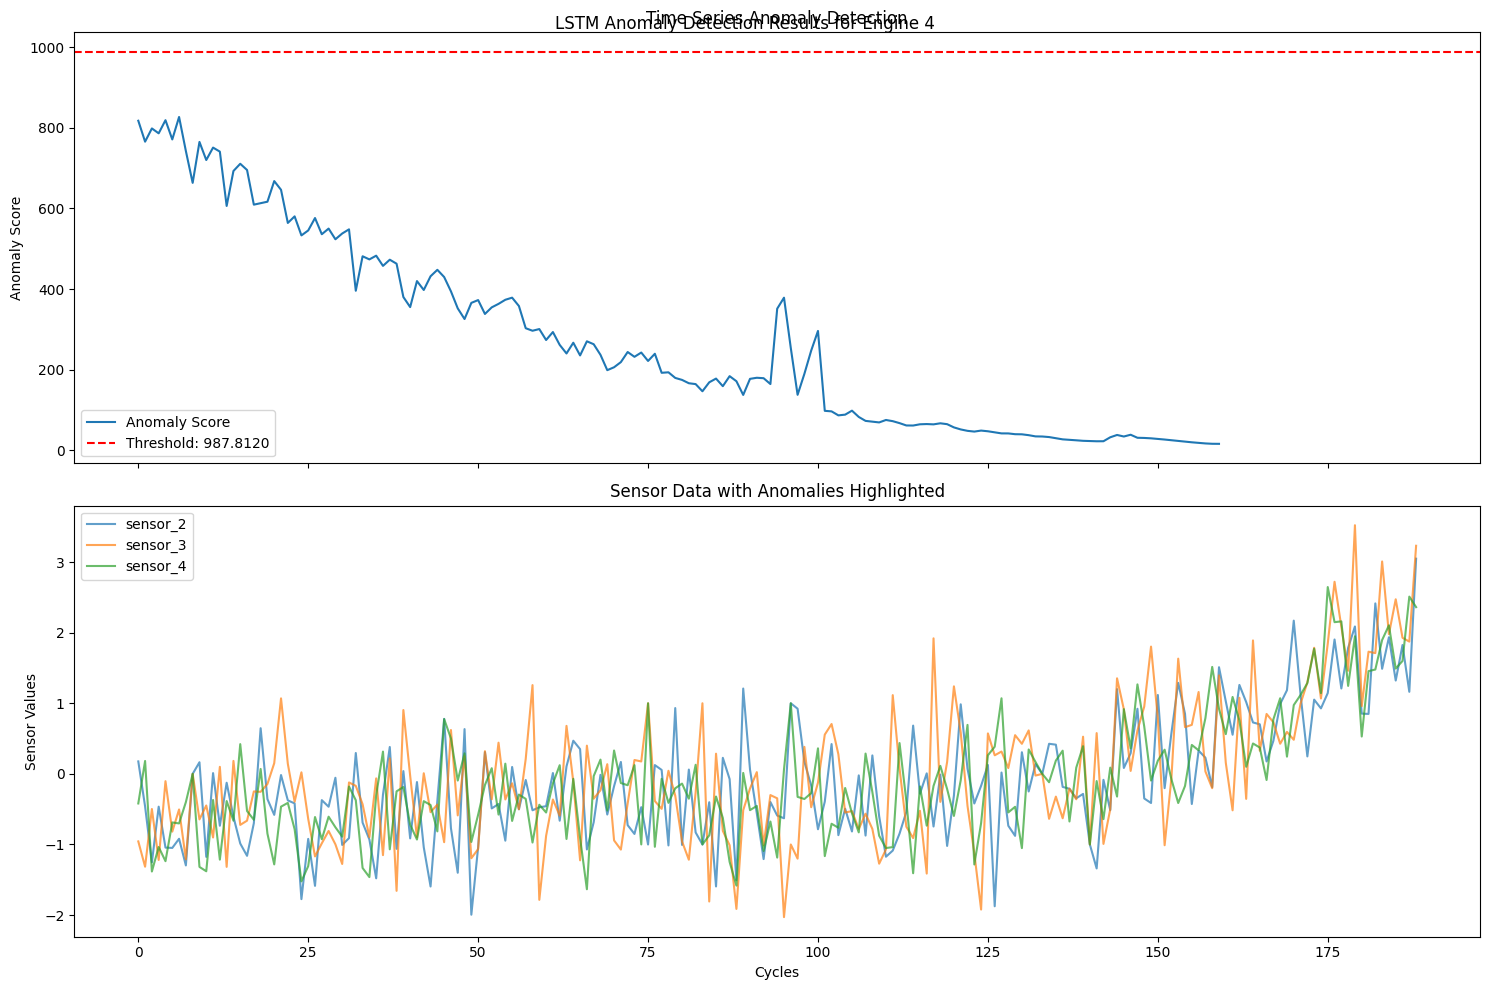

Detecting anomalies for engine 5...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


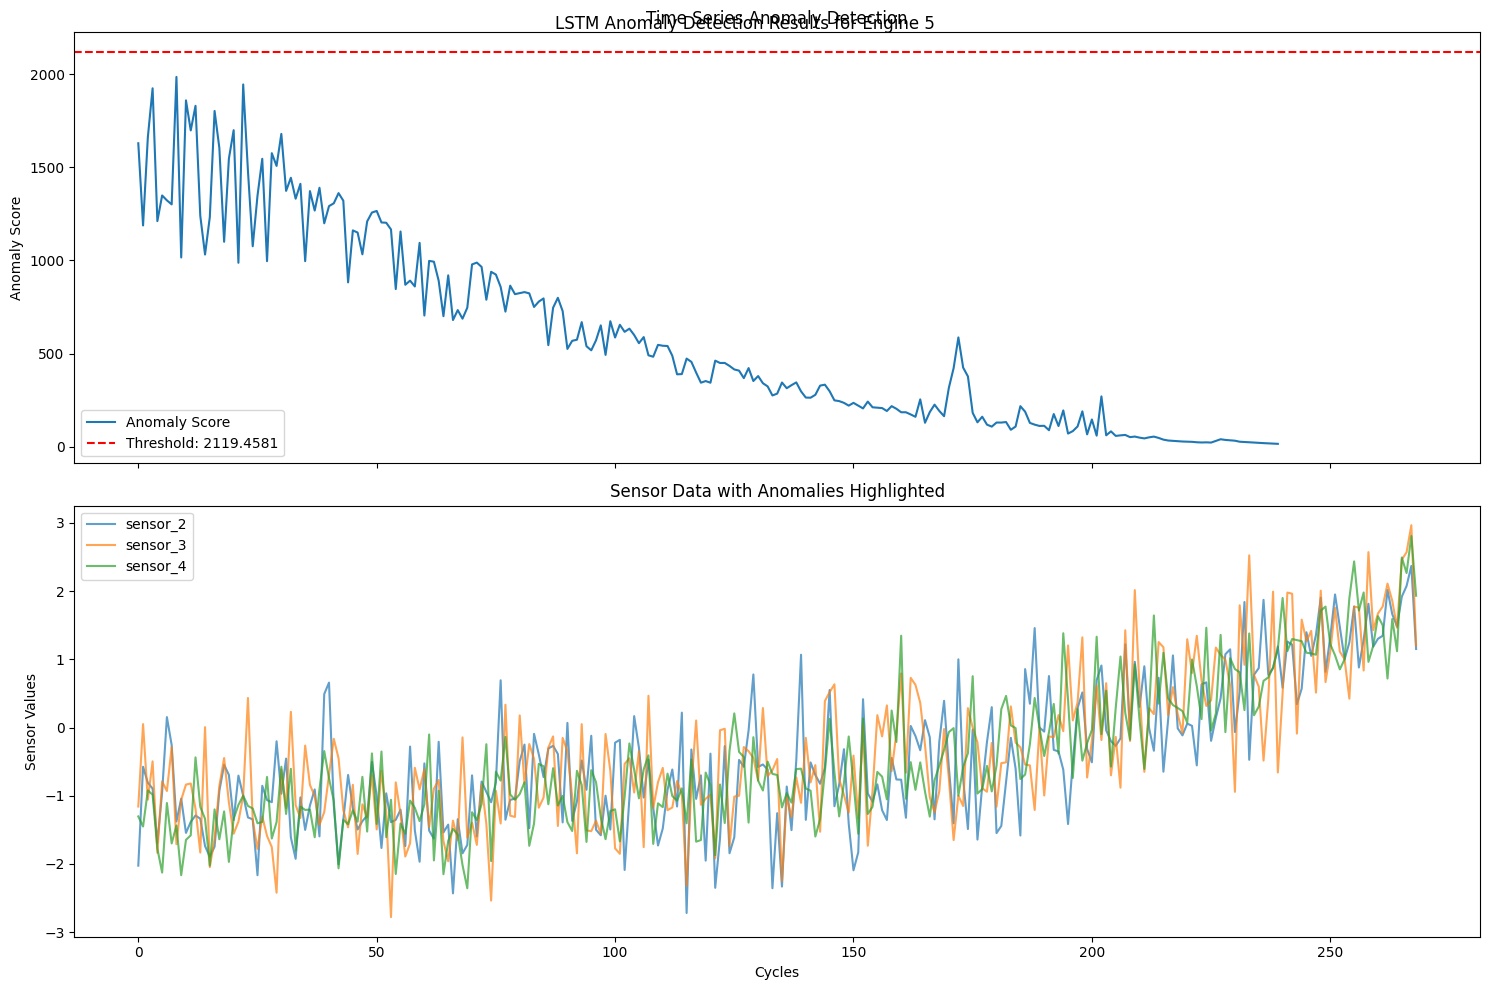

Analysis completed!

===== Analyzing FD002 =====
Processing FD002 dataset...
Creating sequences for engine 1...
Creating sequences for engine 2...
Creating sequences for engine 3...
Creating sequences for engine 4...
Creating sequences for engine 5...
Training LSTM Autoencoder...
✅ Models saved to: models/FD002
Detecting anomalies for engine 4...
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step


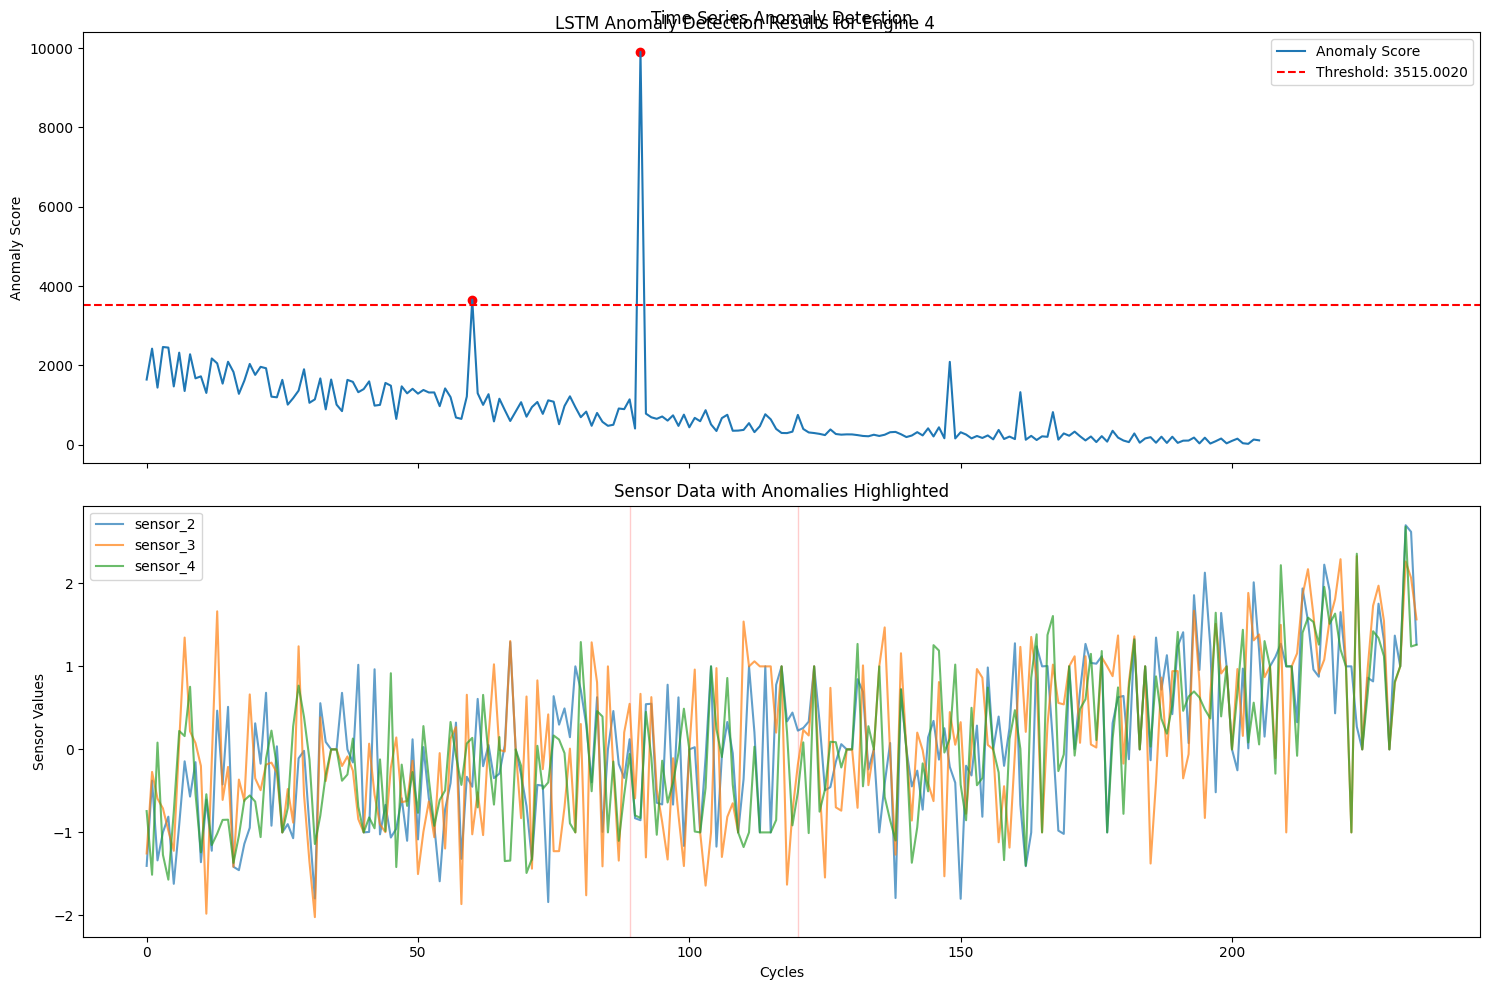

Detecting anomalies for engine 5...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


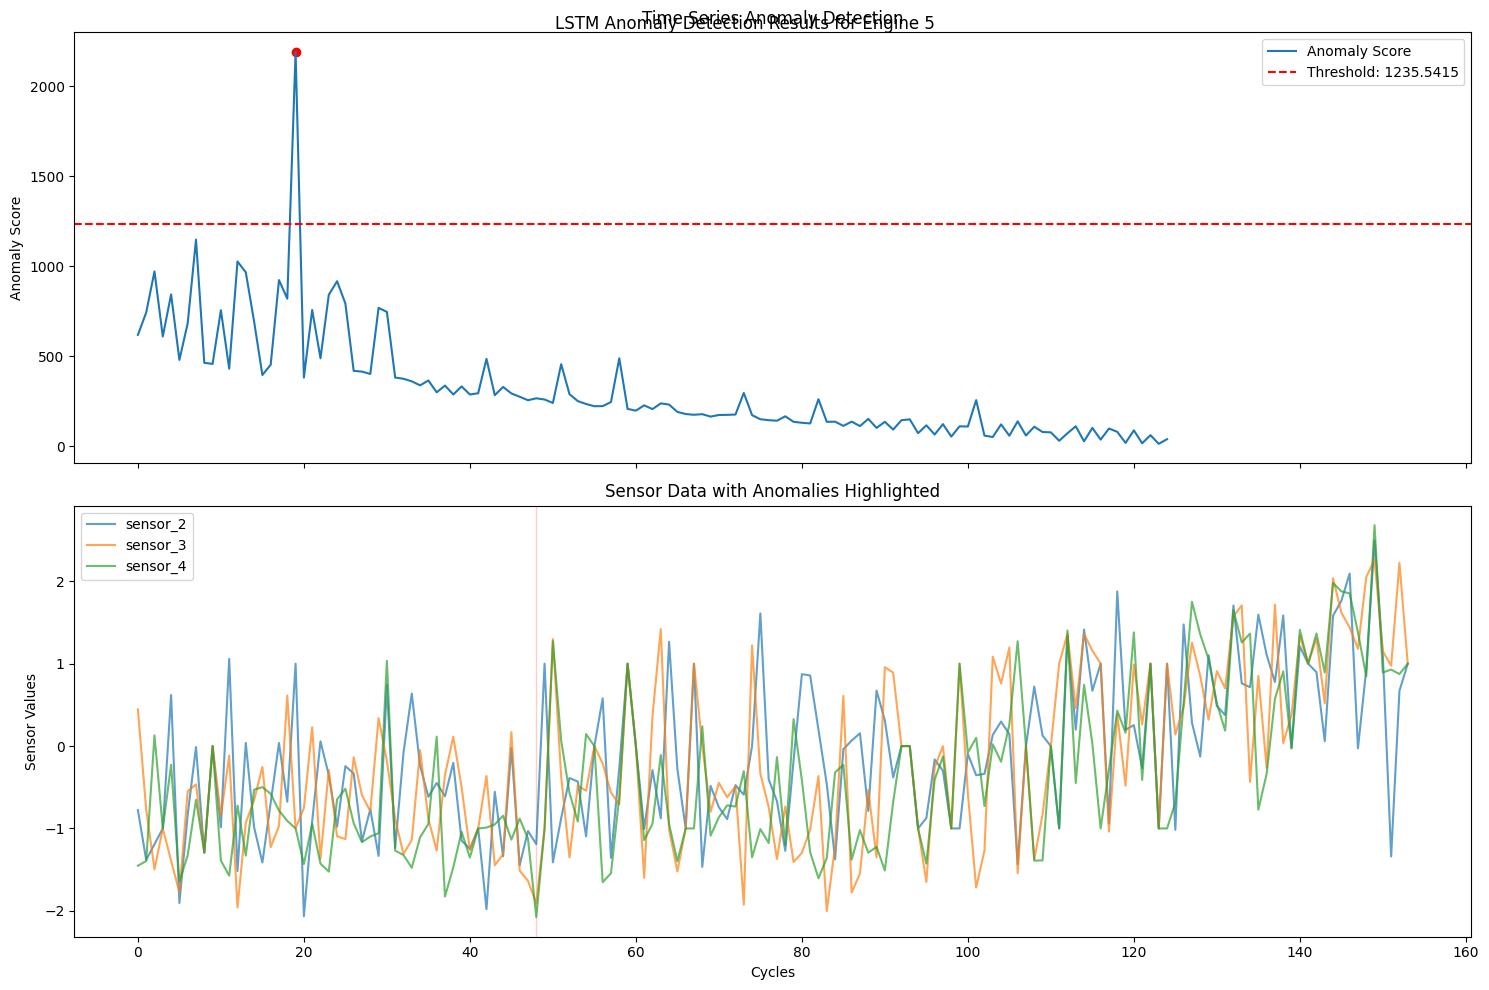

Analysis completed!

===== Analyzing FD003 =====
Processing FD003 dataset...
Creating sequences for engine 1...
Creating sequences for engine 2...
Creating sequences for engine 3...
Creating sequences for engine 4...
Creating sequences for engine 5...
Training LSTM Autoencoder...
✅ Models saved to: models/FD003
Detecting anomalies for engine 4...
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step


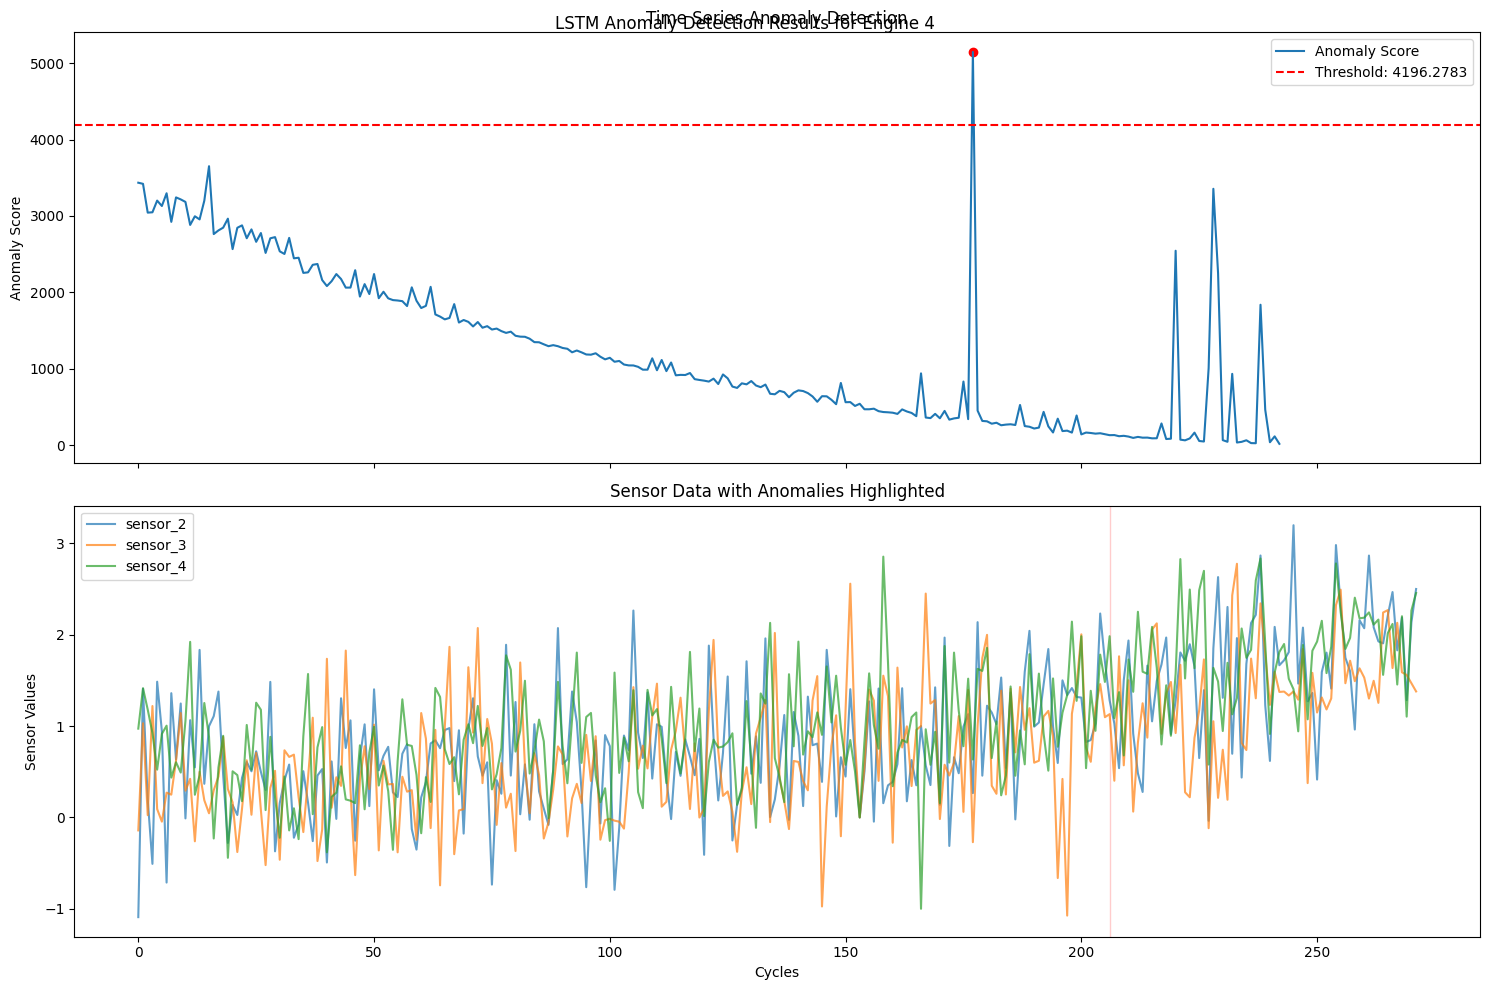

Detecting anomalies for engine 5...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


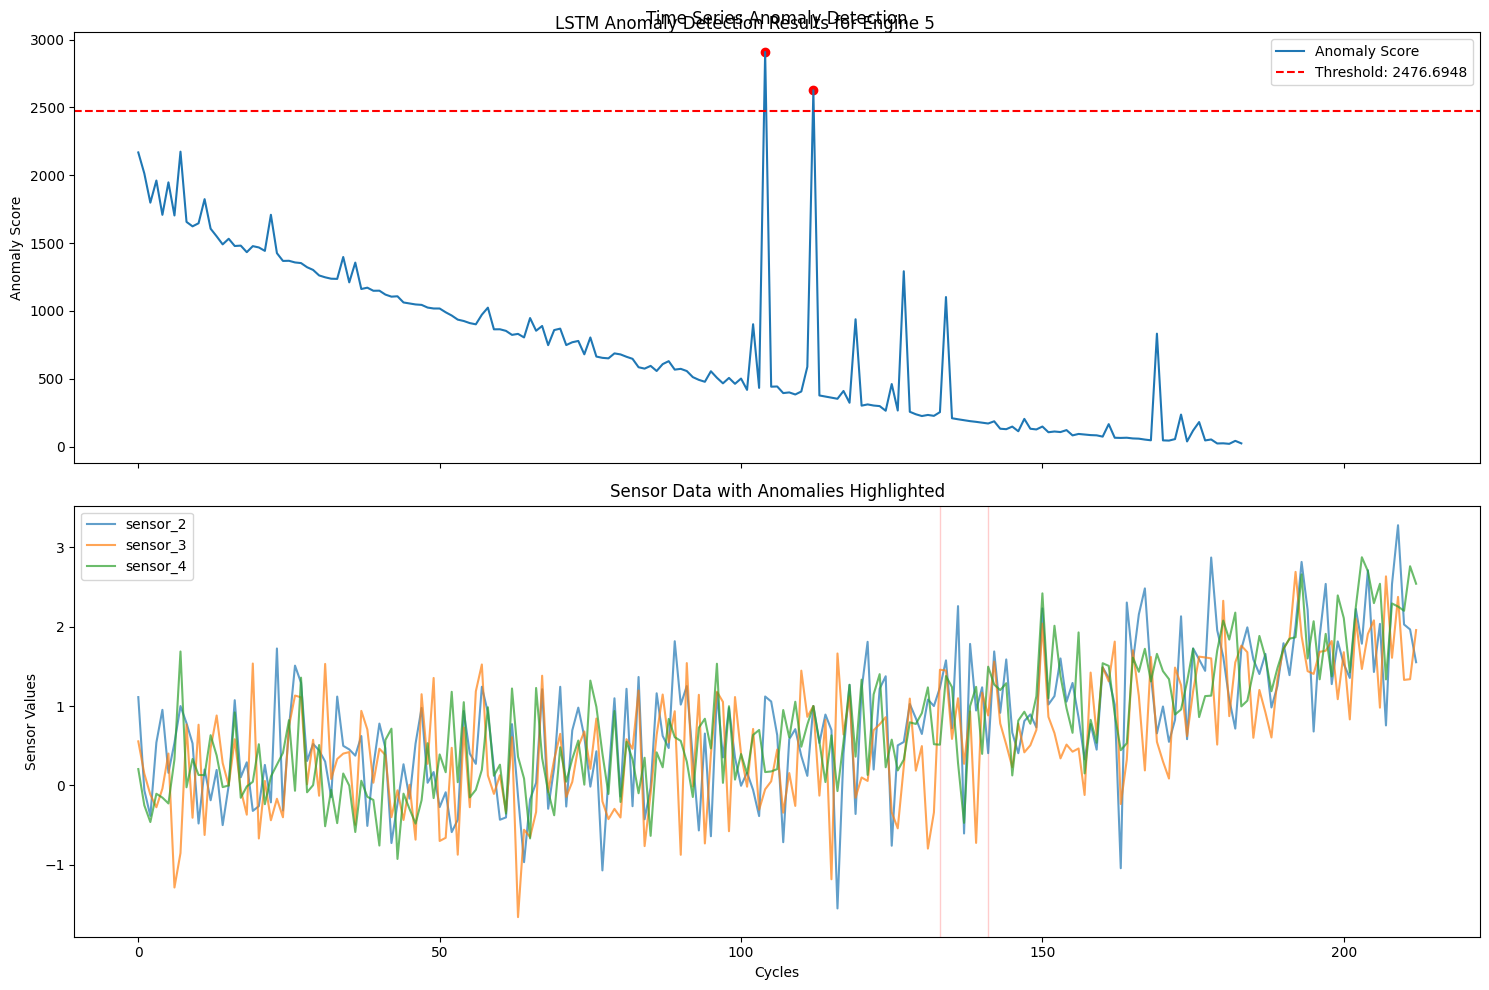

Analysis completed!

===== Analyzing FD004 =====
Processing FD004 dataset...
Creating sequences for engine 1...
Creating sequences for engine 2...
Creating sequences for engine 3...
Creating sequences for engine 4...
Creating sequences for engine 5...
Training LSTM Autoencoder...
✅ Models saved to: models/FD004
Detecting anomalies for engine 4...
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


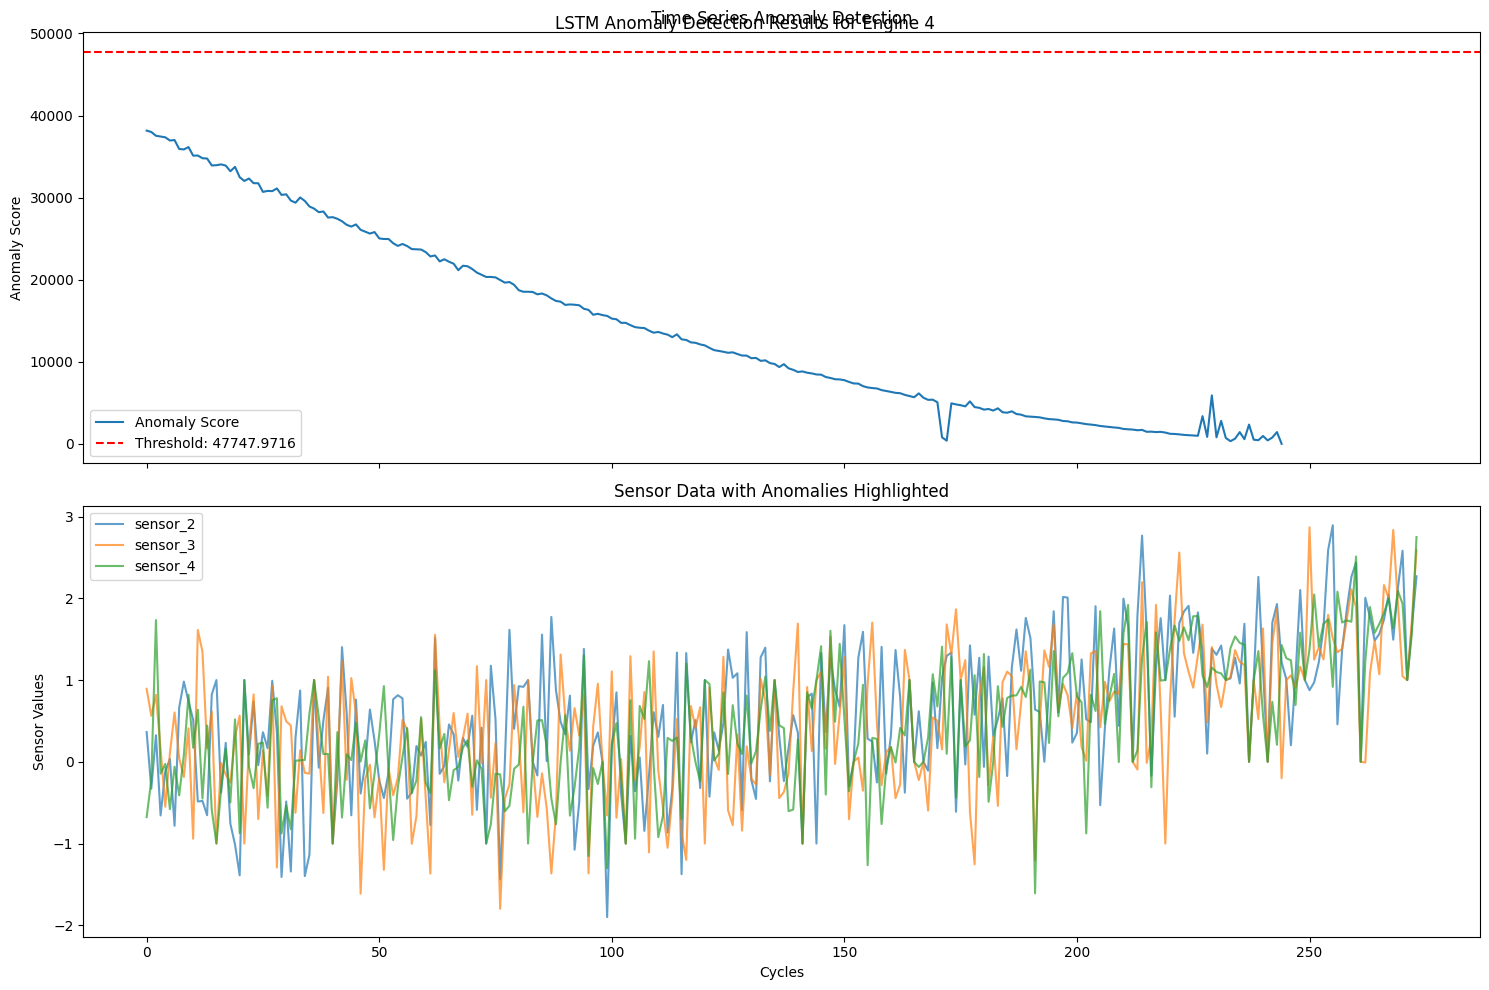

Detecting anomalies for engine 5...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


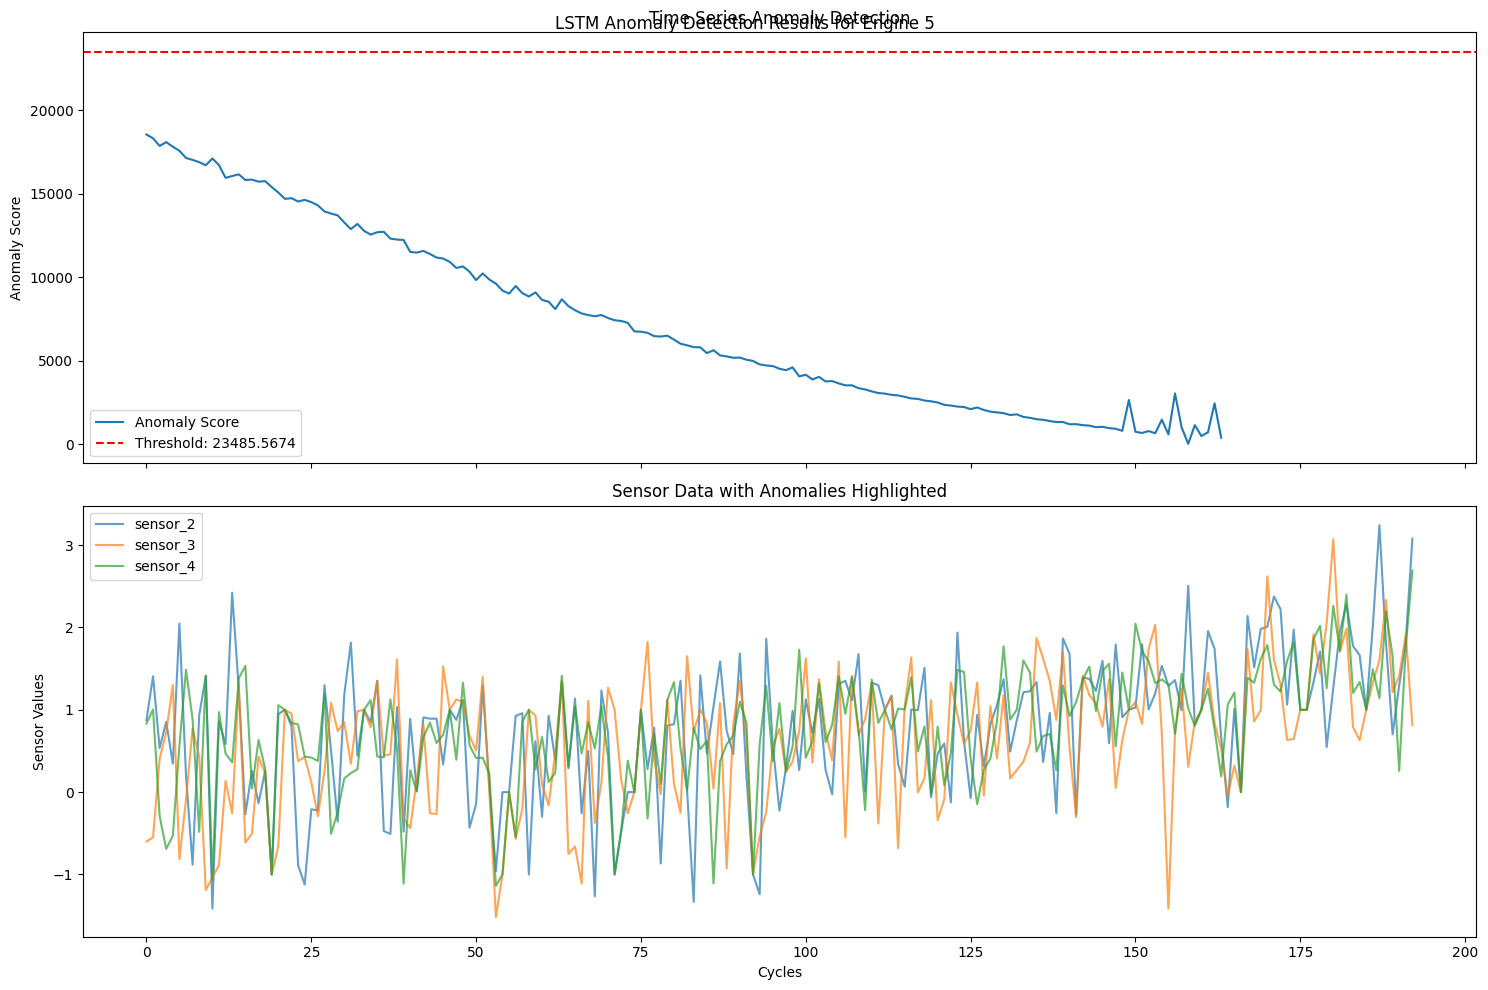

Analysis completed!

===== Performance Comparison =====
Detailed per-engine anomaly detection performance for FD001 and FD004:

FD001:
  Engine 4:
    LSTM anomaly rate:       0.0000
    Statistical anomaly rate: 0.0000
    Wavelet anomaly rate:     0.0000
    Ensemble anomaly rate:    0.0000
  Engine 5:
    LSTM anomaly rate:       0.0000
    Statistical anomaly rate: 0.0000
    Wavelet anomaly rate:     0.0000
    Ensemble anomaly rate:    0.0000

  Average anomaly rates for FD001:
    LSTM anomaly rate:       0.0000
    Statistical anomaly rate: 0.0000
    Wavelet anomaly rate:     0.0000
    Ensemble anomaly rate:    0.0000

FD002:
  Engine 4:
    LSTM anomaly rate:       0.0097
    Statistical anomaly rate: 0.0000
    Wavelet anomaly rate:     0.0000
    Ensemble anomaly rate:    0.0000
  Engine 5:
    LSTM anomaly rate:       0.0080
    Statistical anomaly rate: 0.0000
    Wavelet anomaly rate:     0.0000
    Ensemble anomaly rate:    0.0000

  Average anomaly rates for FD002:
  

In [ ]:
def compare_all_fd_datasets():
    """
    Compare anomaly detection performance across all CMAPSS datasets (FD001 to FD004)

    Returns:
    dict: Performance metrics for each dataset
    """
    results = {}

    for dataset_id in ['FD001', 'FD002', 'FD003', 'FD004']:
        print(f"\n===== Analyzing {dataset_id} =====")
        analysis_results = analyze_cmapss_dataset(dataset_id=dataset_id)
        results[dataset_id] = analysis_results

        # Calculate and print metrics
        metrics = {}
        for engine_id, engine_results in analysis_results['results'].items():
            lstm_anomalies = np.sum(engine_results['lstm']['flags'])
            stat_anomalies = np.sum(engine_results['statistical']['flags'])
            wav_anomalies = np.sum(engine_results['wavelet']['flags'])
            ensemble_anomalies = np.sum(engine_results['ensemble']['flags'])
            total_points = len(engine_results['lstm']['flags'])

            metrics[engine_id] = {
                'lstm_anomaly_rate': lstm_anomalies / total_points,
                'statistical_anomaly_rate': stat_anomalies / total_points,
                'wavelet_anomaly_rate': wav_anomalies / total_points,
                'ensemble_anomaly_rate': ensemble_anomalies / total_points,
                'total_points': total_points
            }

        results[dataset_id]['metrics'] = metrics

    return results


# Main execution
results = compare_all_fd_datasets()

print("\n===== Performance Comparison =====")
print("Detailed per-engine anomaly detection performance for FD001 and FD004:")

for dataset_id in ['FD001', 'FD002', 'FD003', 'FD004']:
    metrics = results[dataset_id]['metrics']
    print(f"\n{dataset_id}:")

    # To calculate averages per anomaly type
    lstm_rates = []
    statistical_rates = []
    wavelet_rates = []
    ensemble_rates = []

    for engine_id, engine_metrics in sorted(metrics.items()):
        print(f"  Engine {engine_id}:")
        print(f"    LSTM anomaly rate:       {engine_metrics['lstm_anomaly_rate']:.4f}")
        print(f"    Statistical anomaly rate: {engine_metrics['statistical_anomaly_rate']:.4f}")
        print(f"    Wavelet anomaly rate:     {engine_metrics['wavelet_anomaly_rate']:.4f}")
        print(f"    Ensemble anomaly rate:    {engine_metrics['ensemble_anomaly_rate']:.4f}")

        lstm_rates.append(engine_metrics['lstm_anomaly_rate'])
        statistical_rates.append(engine_metrics['statistical_anomaly_rate'])
        wavelet_rates.append(engine_metrics['wavelet_anomaly_rate'])
        ensemble_rates.append(engine_metrics['ensemble_anomaly_rate'])

    # Print average anomaly rates per dataset
    print(f"\n  Average anomaly rates for {dataset_id}:")
    print(f"    LSTM anomaly rate:       {sum(lstm_rates) / len(lstm_rates):.4f}")
    print(f"    Statistical anomaly rate: {sum(statistical_rates) / len(statistical_rates):.4f}")
    print(f"    Wavelet anomaly rate:     {sum(wavelet_rates) / len(wavelet_rates):.4f}")
    print(f"    Ensemble anomaly rate:    {sum(ensemble_rates) / len(ensemble_rates):.4f}")
